# QML-RG Homework 7
## Predicting the stock market with Phased LSTMs
### Alejandro Pozas-Kerstjens

p-LSTM cells introduced in https://github.com/dannyneil/public_plstm, Keras implementation from https://github.com/fferroni/PhasedLSTM-Keras

The idea of the notebook is the following: We have a collection of values for stocks, and given the evolution of all but one of them, we want to predict what will be the value of the remaining one on the last (think of it as the current) moment.

In [1]:
import numpy as np
import pandas as pd

from keras.layers.core import Dense
from keras.models import Sequential
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt

try:              # For downloading the dataset
    from urllib2 import Request, urlopen
except ImportError:
    from urllib.request import Request, urlopen
import zipfile    # For unzipping the dataset
    
from phased_lstm_keras.PhasedLSTM import PhasedLSTM    #Phased LSTM implementation

Using TensorFlow backend.


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00312/dow_jones_index.zip"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
content = urlopen(req).read()

with open("dow_jones_index.zip", 'wb') as f:
    f.write(content)

with zipfile.ZipFile("dow_jones_index.zip","r") as zip_ref:
    zip_ref.extractall("dow_jones_index")

In [3]:
prices_dataset =  pd.read_csv('dow_jones_index/dow_jones_index.data', header=0)

# To remove the dollar signs
#def drop_dollar(string):
#    result = string.replace("$", " ")
#    return " ".join(result.split())

#for col in ['open', 'high', 'low', 'close', 'next_weeks_open', 'next_weeks_close']:
#    prices_dataset[col] = prices_dataset[col].apply(lambda x: drop_dollar(x))

prices_dataset

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.792670,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.428490,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.470660,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.638310,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.933250,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029
5,1,AA,2/11/2011,$17.33,$17.48,$16.97,$17.37,114691279,0.230814,-25.712195,154387761.0,$17.39,$17.28,-0.632547,90,0.172712
6,1,AA,2/18/2011,$17.39,$17.68,$17.28,$17.28,80023895,-0.632547,-30.226696,114691279.0,$16.98,$16.68,-1.766780,83,0.173611
7,1,AA,2/25/2011,$16.98,$17.15,$15.96,$16.68,132981863,-1.766780,66.177694,80023895.0,$16.81,$16.58,-1.368230,76,0.179856
8,1,AA,3/4/2011,$16.81,$16.94,$16.13,$16.58,109493077,-1.368230,-17.663150,132981863.0,$16.58,$16.03,-3.317250,69,0.180941
9,1,AA,3/11/2011,$16.58,$16.75,$15.42,$16.03,114332562,-3.317250,4.419900,109493077.0,$15.95,$16.11,1.003130,62,0.187149


In [4]:
stocks = [prices_dataset['stock'][0]]
for stock in prices_dataset['stock']:
    if stocks[-1] != stock:
        stocks.append(stock)
        
stocks = stocks[0:int(len(stocks)/2)]    #Remove duplicates

In [5]:
# Arrange the percent change in stocks and store the weekly values
prices = []
for stock in stocks:
    stockinfo = prices_dataset[prices_dataset['stock']==stock]
    prices.append(stockinfo.percent_change_price.values.astype('float32'))
prices = np.array(prices)

# Read the percent change for the next week
nw_prices = []
for stock in stocks:
    stockinfo = prices_dataset[prices_dataset['stock']==stock]
    nw_prices.append(stockinfo.percent_change_next_weeks_price.values.astype('float32'))
nw_prices = np.array(nw_prices)

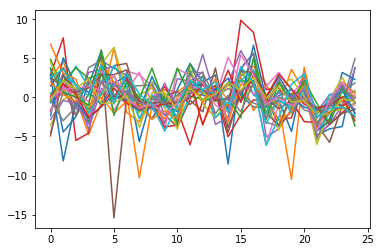

In [6]:
for i in range(len(prices)):
    plt.plot(prices[i])
plt.show()

In [7]:
# Define training and test sets
trainX, testX = prices[0:prices.shape[0]-1,:], prices[-1,:]
trainY, testY = nw_prices[0:nw_prices.shape[0]-1,-1], nw_prices[-1,-1]

#Reshapings to feed the NN correctly
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((1, testX.shape[0], 1))

In [8]:
# Build pLSTM Model
model_plstm = Sequential()

model_plstm.add(PhasedLSTM(100, input_shape=(25, 1), dropout=0.2))

model_plstm.add(Dense(1, activation='linear'))

model_plstm.compile(loss='mse', optimizer='adam')

# And LSTM model to compare
model_lstm = Sequential()

model_lstm.add(LSTM(100, input_shape=(25, 1), dropout=0.2))

model_lstm.add(Dense(1, activation='linear'))

model_lstm.compile(loss='mse', optimizer='adam')

In [9]:
model_plstm.fit(trainX, trainY, epochs=20, batch_size=1)
model_lstm.fit(trainX, trainY, epochs=20, batch_size=1)

Epoch 1/20
29/29 [==============================] - 1s - loss: 28.8505      
Epoch 2/20
29/29 [==============================] - 0s - loss: 26.5135     

In [10]:
pred_plstm = model_plstm.predict(testX)
pred_lstm = model_lstm.predict(testX)

err_plstm = abs(pred_plstm[0][0] - testY) / testY
err_lstm = abs(pred_lstm[0][0] - testY) / testY

print('The error with Phased LSTM is {}, while with LSTM is {}'.format(err_plstm, err_lstm))

The error with Phased LSTM is 0.08319906890392303, while with LSTM is 0.27037063241004944
